In [1]:
"""
This script computes the LPIPS, SSIM and ORB metrics betweeen corresponding image pairs
1- Experimental images
2- Diffusion conditioned on simulated images

"""

'\nThis script computes the LPIPS, SSIM and ORB metrics betweeen corresponding image pairs\n1- Experimental images\n2- Diffusion conditioned on simulated images\n\n'

In [2]:
# import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2

from cldm.preprocess import preprocess_simulation_graybackground,preprocess_experimental_backgroundwhite
from cldm.config import EXP_FOLDER_TEST,SIM_FOLDER_TEST, MAIN_FOLDER
from cldm.metrics import display_images_with_ssim, calculate_lpips_score_batch,calculate_orb_similarity_batch,calculate_ssim_batch

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/hpc/group/youlab/rah94/miniconda3/envs/pytorch_PA_patternprediction/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/hpc/group/youlab/rah94/miniconda3/envs/pytorch_PA_patternprediction/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /hpc/group/youlab/rah94/miniconda3/envs/pytorch_PA_patternprediction/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


In [3]:

# Paths to three folders
exp_folder = EXP_FOLDER_TEST
sim_folder = SIM_FOLDER_TEST
pred_folder = MAIN_FOLDER

def load_image_batch(folder, exts=(".tif", ".png", ".jpg", ".jpeg"), type=None, size=(256,256)):
    files = sorted(f for f in os.listdir(folder) if f.lower().endswith(exts))
    batch = []
    for fname in files:
        path = os.path.join(folder, fname)

        if type == 'sim':
            img = preprocess_simulation_graybackground(path)              # HxW uint8
        elif type == 'exp':
            img = preprocess_experimental_backgroundwhite(path)           # HxWx3 uint8 RGB
        else:
            img = np.array(Image.open(path).convert("RGB"))               # HxWx3 uint8 RGB

        # --- normalize shapes/channels/sizes ---
        if img.ndim == 2:                         # grayscale -> RGB
            img = np.stack([img]*3, axis=-1)
        elif img.shape[-1] == 4:                  # drop alpha if present
            img = img[..., :3]

        if img.dtype != np.uint8:                 # force uint8 before scaling
            img = np.clip(img, 0, 255).astype(np.uint8) if img.max() > 1.0 else (img*255).astype(np.uint8)

        if (img.shape[1], img.shape[0]) != size:  # ensure 256x256
            img = cv2.resize(img, size, interpolation=cv2.INTER_LANCZOS4)

        # to torch CHW, float32 in [0,1]
        img_t = torch.from_numpy(img).permute(2,0,1).float() / 255.0
        batch.append(img_t)

    return torch.stack(batch)  # [N,3,256,256]

# load batches
exp_images  = load_image_batch(exp_folder, type='exp')
sim_images  = load_image_batch(sim_folder,type='sim')
pred_images = load_image_batch(pred_folder)


# print the shapes of experimental, simulated and predicted images
print(f"Experimental images shape: {exp_images.shape}")
print(f"Simulated images shape: {sim_images.shape}")
print(f"Predicted images shape: {pred_images.shape}")



Experimental images shape: torch.Size([96, 3, 256, 256])
Simulated images shape: torch.Size([96, 3, 256, 256])
Predicted images shape: torch.Size([96, 3, 256, 256])


Sample 0: ref_image.shape = (3, 256, 256), comp_image.shape = (3, 256, 256)
Sample 1: ref_image.shape = (3, 256, 256), comp_image.shape = (3, 256, 256)
Sample 2: ref_image.shape = (3, 256, 256), comp_image.shape = (3, 256, 256)
Sample 3: ref_image.shape = (3, 256, 256), comp_image.shape = (3, 256, 256)
Sample 4: ref_image.shape = (3, 256, 256), comp_image.shape = (3, 256, 256)


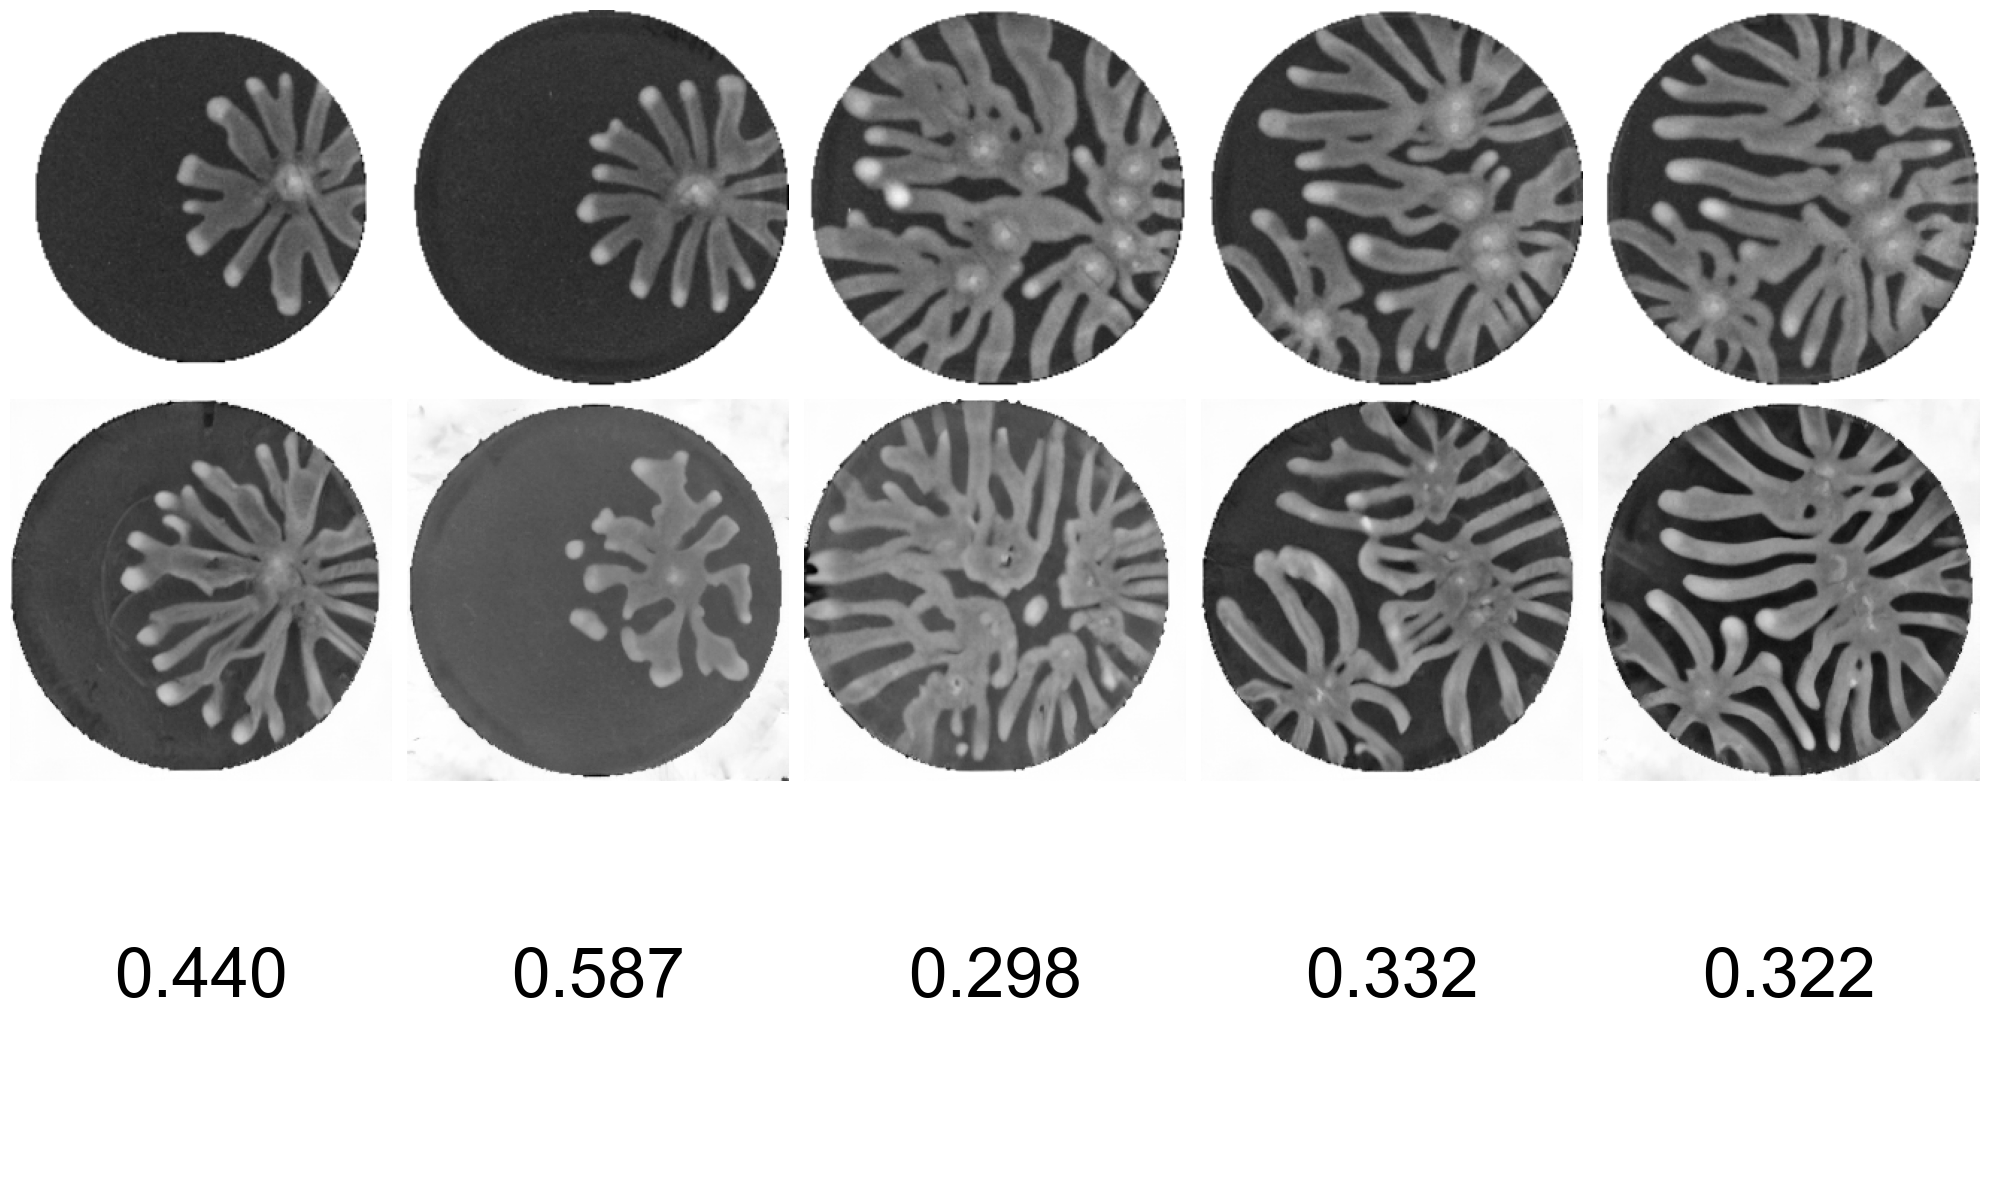

In [4]:
# comparision for experiment and prediction images
selected_indices=[4,5,2,6,7]
display_images_with_ssim(exp_images[selected_indices], pred_images[selected_indices], num_samples=5)

Sample 0: ref_image.shape = (3, 256, 256), comp_image.shape = (3, 256, 256)
Sample 1: ref_image.shape = (3, 256, 256), comp_image.shape = (3, 256, 256)
Sample 2: ref_image.shape = (3, 256, 256), comp_image.shape = (3, 256, 256)
Sample 3: ref_image.shape = (3, 256, 256), comp_image.shape = (3, 256, 256)
Sample 4: ref_image.shape = (3, 256, 256), comp_image.shape = (3, 256, 256)


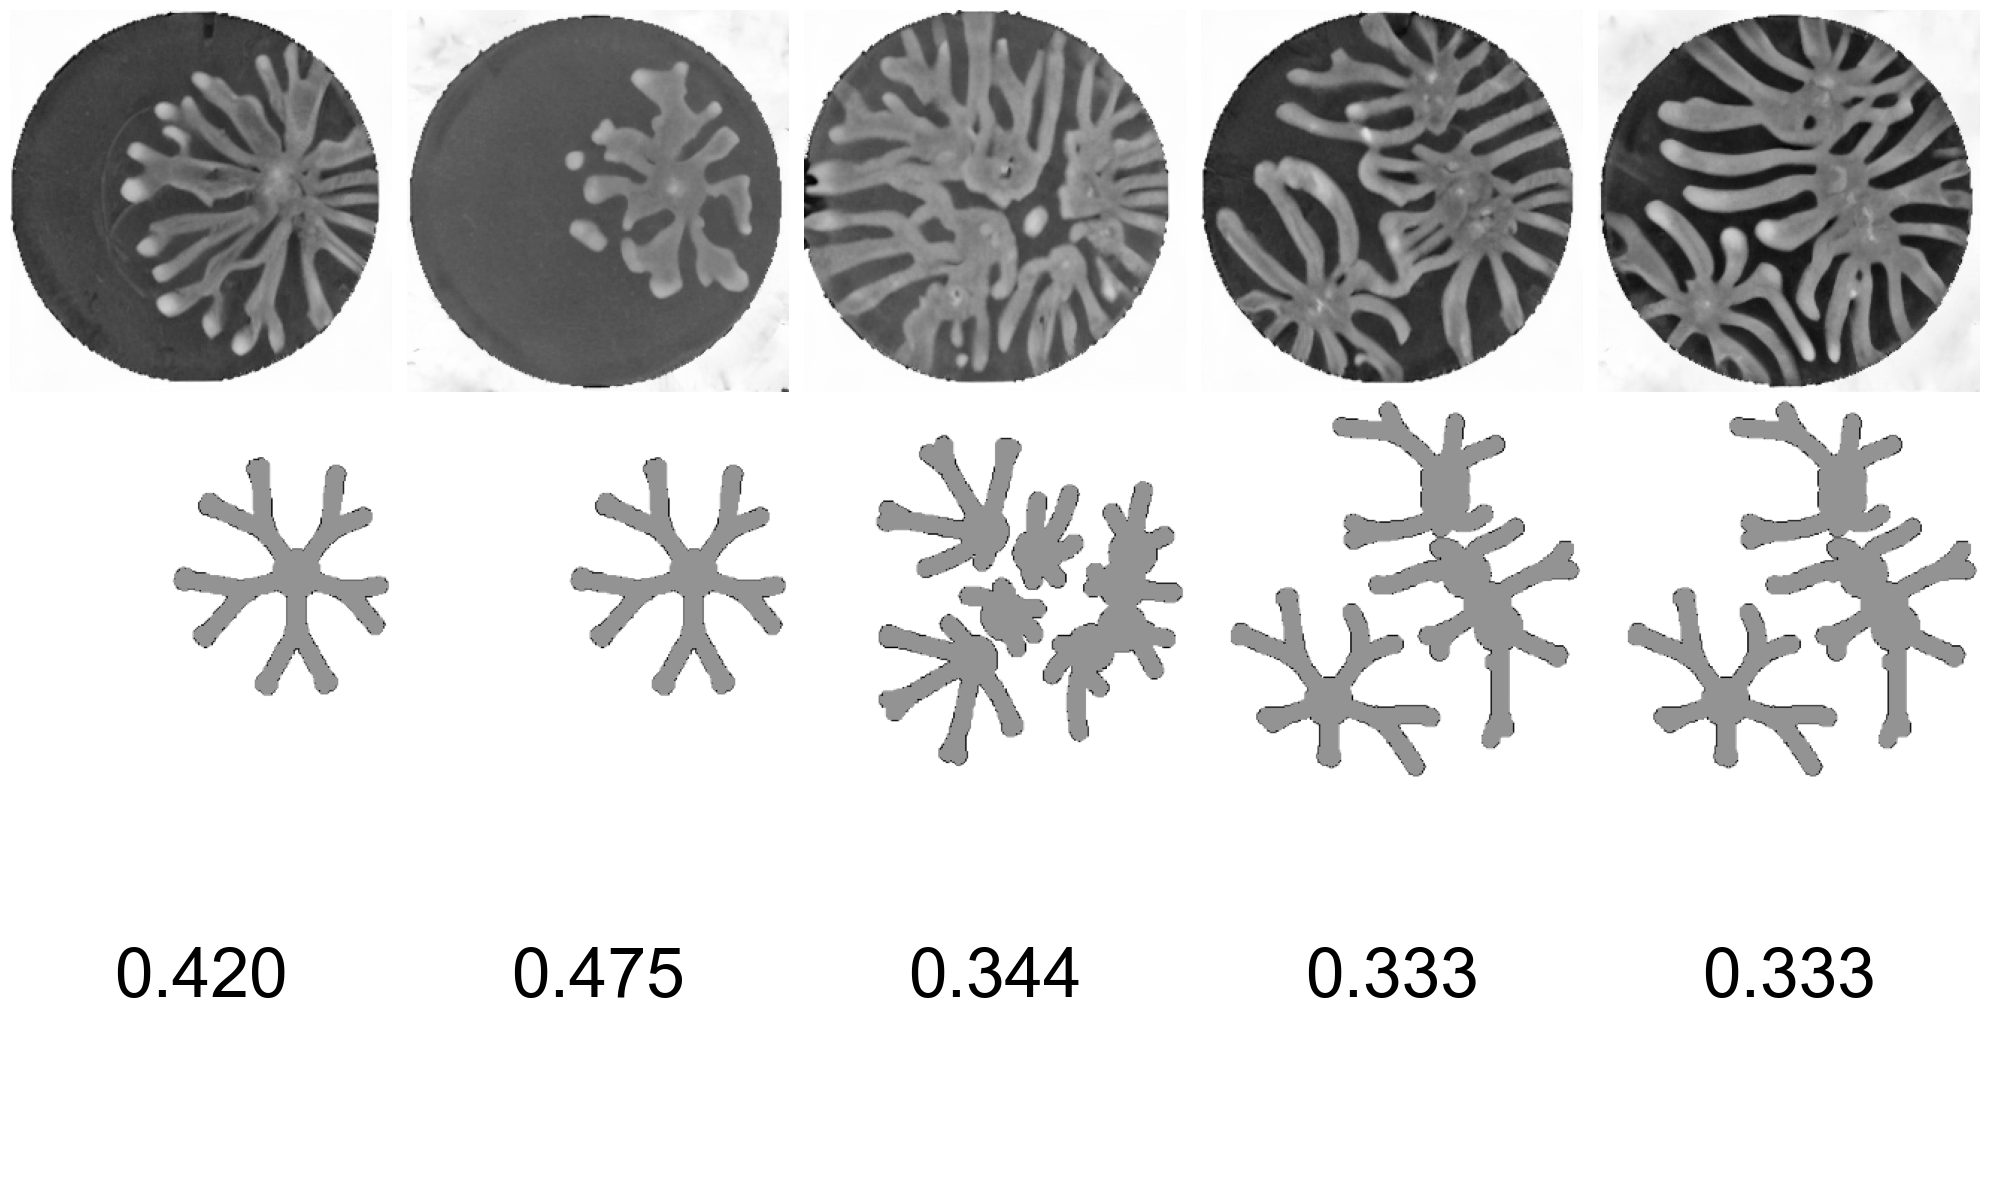

In [5]:
# comparision for experimental and simulation images
selected_indices=[4,5,2,6,7]
display_images_with_ssim(pred_images[selected_indices], sim_images[selected_indices], num_samples=5)

Sample 0: ref_image.shape = (3, 256, 256), comp_image.shape = (3, 256, 256)
Sample 1: ref_image.shape = (3, 256, 256), comp_image.shape = (3, 256, 256)
Sample 2: ref_image.shape = (3, 256, 256), comp_image.shape = (3, 256, 256)
Sample 3: ref_image.shape = (3, 256, 256), comp_image.shape = (3, 256, 256)
Sample 4: ref_image.shape = (3, 256, 256), comp_image.shape = (3, 256, 256)


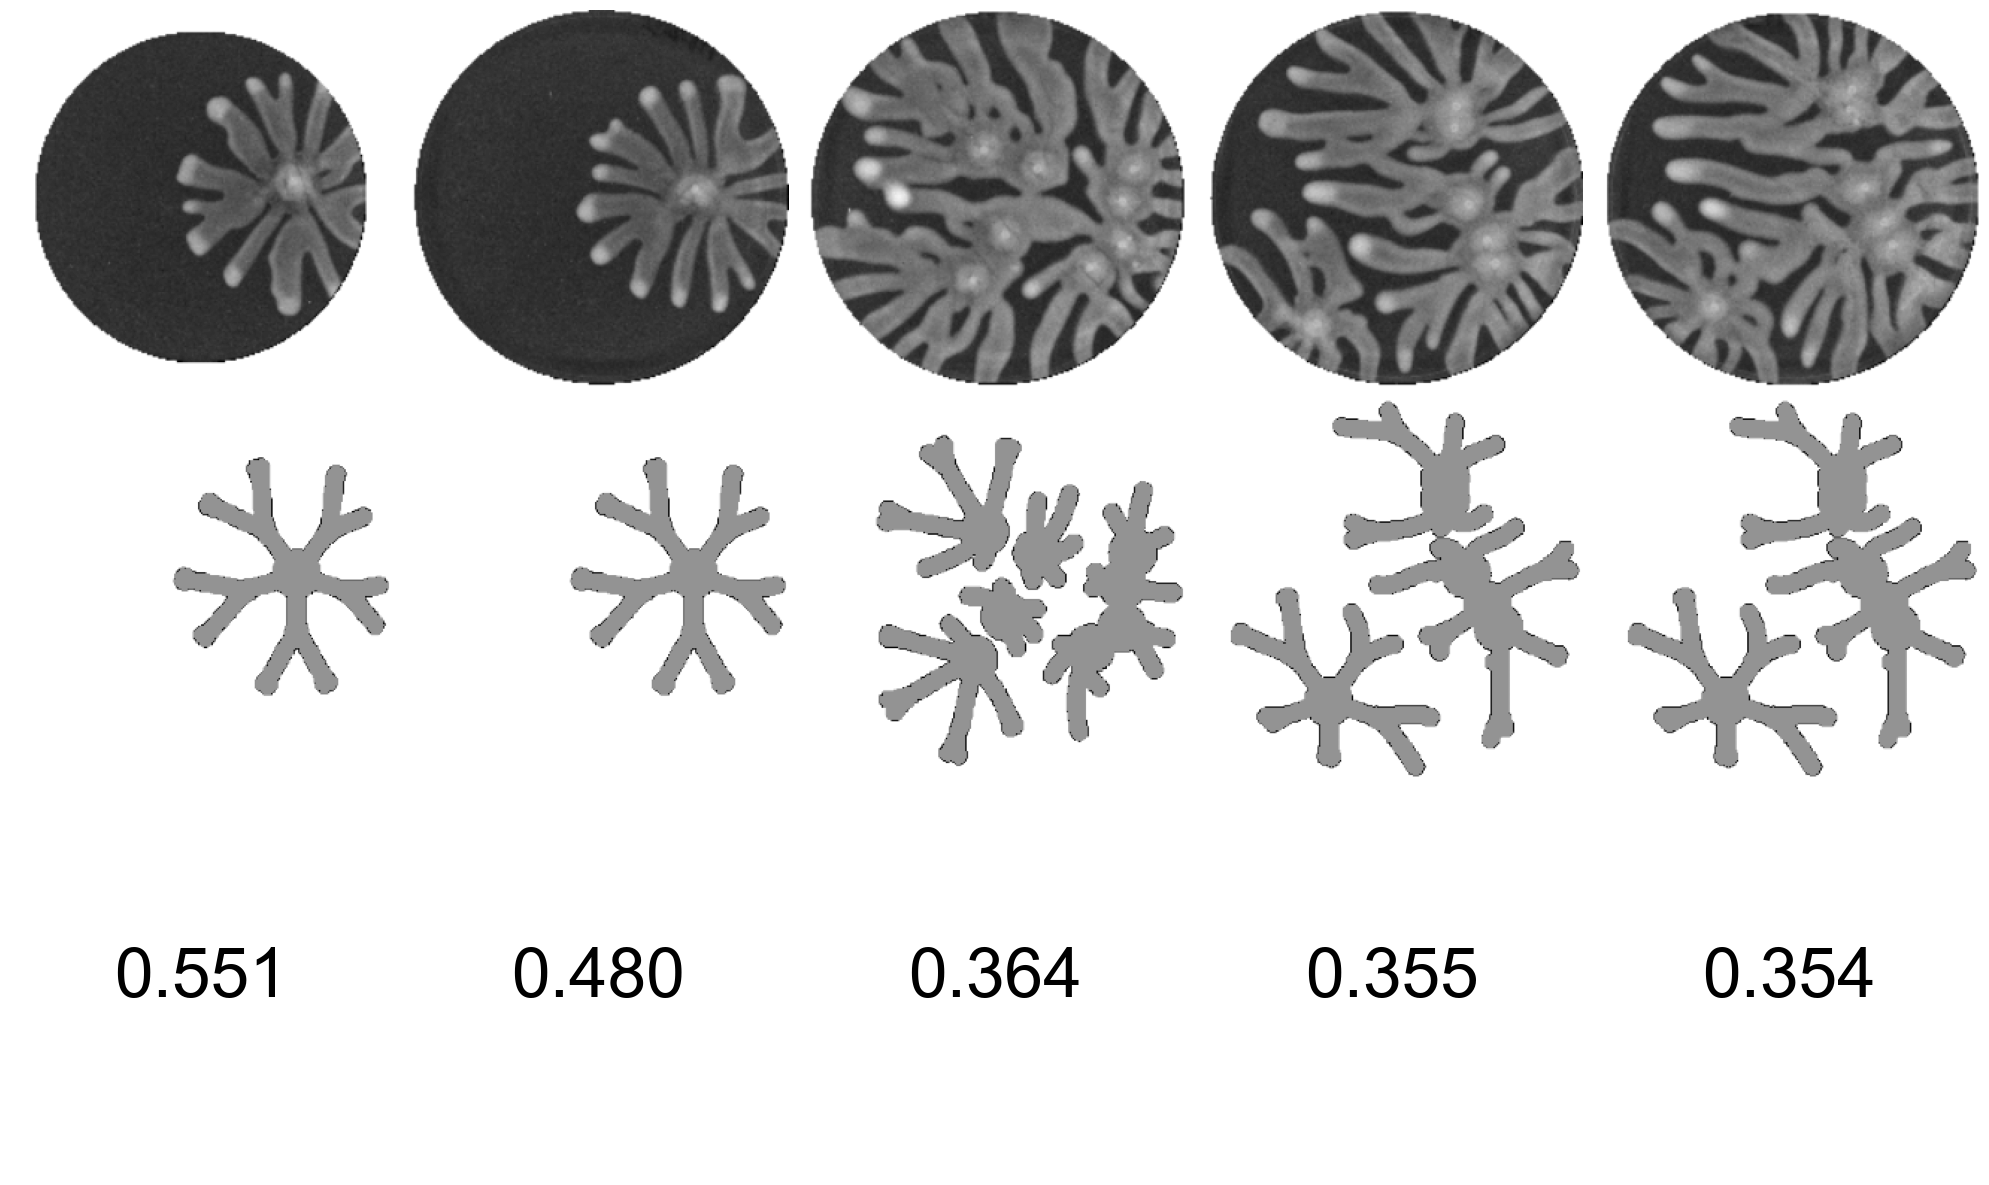

In [6]:
# comparision for experimental and simulation images
selected_indices=[4,5,2,6,7]
display_images_with_ssim(exp_images[selected_indices], sim_images[selected_indices], num_samples=5)

In [7]:
# compute LPIPS
lpips_genAI=calculate_lpips_score_batch(exp_images,pred_images)
lpips_sim=calculate_lpips_score_batch(exp_images,sim_images)
lpips_simgenAI=calculate_lpips_score_batch(sim_images,pred_images)

In [8]:
# compute ORB
orb_similarity_genAI=calculate_orb_similarity_batch(exp_images,pred_images)
orb_similarity_sim=calculate_orb_similarity_batch(exp_images,sim_images)
orb_similarity_simgenAI=calculate_orb_similarity_batch(sim_images,pred_images)

In [9]:
# compute SSIM
ssim_similarity_genAI=calculate_ssim_batch(exp_images,pred_images)
ssim_similarity_sim=calculate_ssim_batch(exp_images,sim_images)
ssim_similarity_simgenAI=calculate_ssim_batch(sim_images,pred_images)

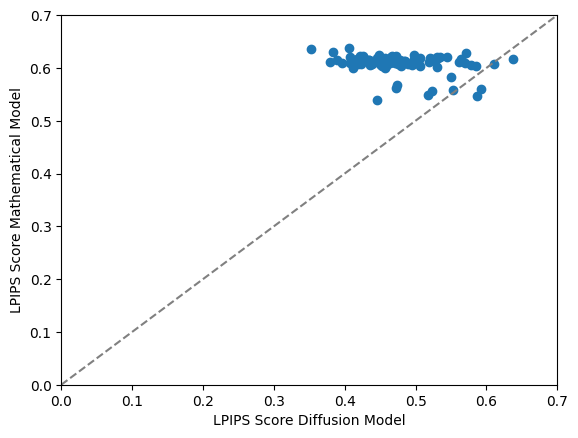

In [10]:
"""These are not in the paper, only to see the distribution of the scores"""
# visualize LPIPS distribution
plt.scatter(lpips_genAI,lpips_sim)

x = np.linspace(0, 0.7, 100)
# Now add y = x line
plt.plot(x, x, color='gray', linestyle='--', label='y = x')

plt.xlabel("LPIPS Score Diffusion Model")
plt.ylabel("LPIPS Score Mathematical Model")
plt.xlim([0,0.7])
plt.ylim([0,0.7])
plt.show()



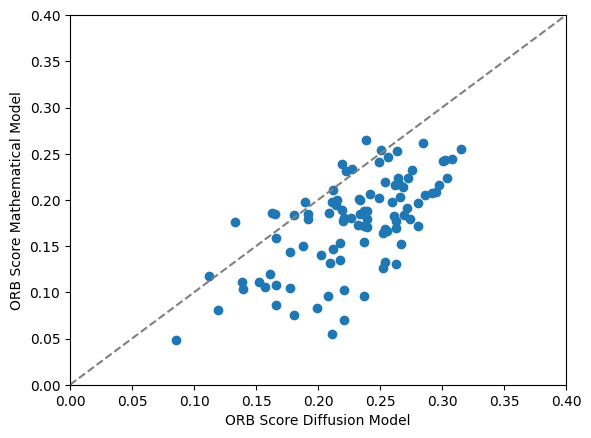

In [11]:
# visualize ORB distribution
plt.scatter(orb_similarity_genAI,orb_similarity_sim)
x = np.linspace(0, 0.5, 100)
# Now add y = x line
plt.plot(x, x, color='gray', linestyle='--', label='y = x')

plt.xlabel("ORB Score Diffusion Model")
plt.ylabel("ORB Score Mathematical Model")
plt.xlim([0,0.4])
plt.ylim([0,0.4])
plt.show()


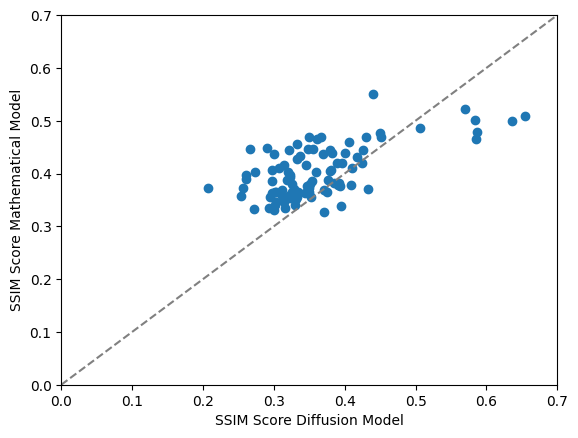

In [12]:
# visualize SSIM distribution
plt.scatter(ssim_similarity_genAI,ssim_similarity_sim)
x = np.linspace(0, 1, 100)
# Now add y = x line
plt.plot(x, x, color='gray', linestyle='--', label='y = x')

plt.xlabel("SSIM Score Diffusion Model")
plt.ylabel("SSIM Score Mathematical Model")
plt.xlim([0,0.7])
plt.ylim([0,0.7])
plt.show()


In [13]:
# Mean+-std of the scores

def print_summary_statistics(scores, name):
    mean_score = np.nanmean(scores)
    std_score = np.nanstd(scores)
    print(f"{name} - Mean: {mean_score:.4f}, Std: {std_score:.4f}")

print_summary_statistics(lpips_sim, "LPIPS Exp and Sim")
print_summary_statistics(ssim_similarity_sim, "SSIM Exp and Sim")
print_summary_statistics(orb_similarity_sim, "ORB Exp and Sim")

print_summary_statistics(lpips_genAI, "LPIPS Exp and Pred")
print_summary_statistics(ssim_similarity_genAI, "SSIM Exp and Pred")
print_summary_statistics(orb_similarity_genAI, "ORB Exp and Pred")

print_summary_statistics(lpips_simgenAI, "LPIPS Sim and Pred")
print_summary_statistics(ssim_similarity_simgenAI, "SSIM Sim and Pred")
print_summary_statistics(orb_similarity_simgenAI, "ORB Sim and Pred")


LPIPS Exp and Sim - Mean: 0.6085, Std: 0.0180
SSIM Exp and Sim - Mean: 0.4019, Std: 0.0491
ORB Exp and Sim - Mean: 0.1748, Std: 0.0504
LPIPS Exp and Pred - Mean: 0.4774, Std: 0.0556
SSIM Exp and Pred - Mean: 0.3608, Std: 0.0803
ORB Exp and Pred - Mean: 0.2284, Std: 0.0472
LPIPS Sim and Pred - Mean: 0.6374, Std: 0.0316
SSIM Sim and Pred - Mean: 0.3294, Std: 0.0482
ORB Sim and Pred - Mean: 0.1987, Std: 0.0377
